# **GAN for Medical Chest X-ray Image Generation**


# Step 1: Combine All Chest X-Ray Images

In [ ]:
import os
import shutil
from glob import glob

In [ ]:
from google.colab import drive
import os

# Remove the mountpoint if it exists and is not empty
if os.path.isdir('/content/drive'):
  if os.listdir('/content/drive'):
    !rm -rf /content/drive/*

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Step 1: Combine all images (NORMAL & PNEUMONIA) into one folder
source_dirs = [
    '/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/train/NORMAL',
    '/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/train/PNEUMONIA',
    '/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/test/NORMAL',
    '/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/test/PNEUMONIA',
    '/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/val/NORMAL',
    '/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/val/PNEUMONIA',
]

target_dir = '/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/all_xray_images'
os.makedirs(target_dir, exist_ok=True)




In [ ]:
for src in source_dirs:
    print("Checking folder:", src)
    print("Files found:", len(glob(os.path.join(src, '*'))))

Checking folder: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/train/NORMAL
Files found: 1341
Checking folder: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/train/PNEUMONIA
Files found: 3875
Checking folder: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/test/NORMAL
Files found: 234
Checking folder: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/test/PNEUMONIA
Files found: 390
Checking folder: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/val/NORMAL
Files found: 8
Checking folder: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/val/PNEUMONIA
Files found: 8


In [ ]:
#for ext in ['*.jpg', '*.jpeg', '*.png', '*.JPG']:
    #for img_path in glob(os.path.join(src, ext)):
        #...


In [ ]:
'''from glob import iglob

for src in source_dirs:
    for img_path in iglob(os.path.join(src, '*.*')):
        ext = os.path.splitext(img_path)[-1]
        filename = f'image_{count:05d}{ext}'
        shutil.copy(img_path, os.path.join(target_dir, filename))
        count += 1

print(f'Total images collected: {count}')'''



Total images collected: 0


In [ ]:
count = 0
for src in source_dirs:
    for img_path in glob(os.path.join(src, '*')):
        ext = os.path.splitext(img_path)[-1]
        filename = f'image_{count:05d}{ext}'
        shutil.copy(img_path, os.path.join(target_dir, filename))
        count += 1

print(f'Total images collected: {count}')

Total images collected: 5856


In [ ]:
num_files = len(os.listdir(target_dir))
print(f"Total files in {target_dir}: {num_files}")

Total files in /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/all_xray_images: 5856


In [ ]:
'''
count = 0
for src in source_dirs:
    print("Checking:", src)
    for img_path in glob(os.path.join(src, '*.*')):
        ext = os.path.splitext(img_path)[-1]
        filename = f'image_{count:05d}{ext}'
        shutil.copy(img_path, os.path.join(target_dir, filename))
        count += 1

print(f"✅ Total images copied: {count}")
'''


Checking: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/train/NORMAL
Checking: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/train/PNEUMONIA
Checking: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/test/NORMAL
Checking: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/test/PNEUMONIA
Checking: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/val/NORMAL
Checking: /content/drive/MyDrive/Udemy_Healthcare_Course_Demo/chest_xray/val/PNEUMONIA
✅ Total images copied: 0


# Step 2: Preprocess Images

In [ ]:
target_dir="/content/drive/MyDrive/Udemy_Healthcare_Course_Demo/all_xray_images"

In [ ]:
## Step 2: Load and preprocess images
import numpy as np
from PIL import Image
import tensorflow as tf

def load_images(path, image_size=(64, 64)):
    images = []
    for img_path in glob(path + '/*'):
        img = Image.open(img_path).convert('L').resize(image_size)
        img = np.array(img).astype('float32') / 127.5 - 1.0
        images.append(img)
    return np.expand_dims(np.array(images), axis=-1)

data = load_images(target_dir)
BUFFER_SIZE = data.shape[0]
BATCH_SIZE = 32
dataset = tf.data.Dataset.from_tensor_slices(data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

print("Shape of dataset:", data.shape)

Shape of dataset: (5856, 64, 64, 1)


# Step 3: Define Generator & Discriminator

In [ ]:
## Step 3: Define Generator and Discriminator
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(100,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),
        layers.Conv2DTranspose(128, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Conv2DTranspose(1, 5, strides=2, padding='same', use_bias=False, activation='tanh')
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        layers.Conv2D(64, 5, strides=2, padding='same', input_shape=(64, 64, 1)),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(128, 5, strides=2, padding='same'),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(1)
    ])
    return model

# Step 4: Losses & Optimizers

In [ ]:
## Step 4: Loss and Optimizer
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return cross_entropy(tf.ones_like(real_output), real_output) + \
           cross_entropy(tf.zeros_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Step 5: Training Loop + Discriminator Output

In [ ]:
## Step 5: Training Step
EPOCHS = 5
noise_dim = 100
seed = tf.random.normal([16, noise_dim])

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_gen, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_disc, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Step 6: Display Generated & Real Images with Discriminator Scores

In [ ]:
## Step 6: Generate Images for Visual Comparison
import matplotlib.pyplot as plt

def generate_images(epoch, test_input, real_images):
    fake_images = generator(test_input, training=False)
    fake_images = (fake_images + 1) / 2.0
    real_images = (real_images + 1) / 2.0

    d_fake_pred = discriminator(fake_images, training=False)
    d_real_pred = discriminator(real_images, training=False)

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
    fig.suptitle(f"Epoch {epoch} — D(real): {tf.reduce_mean(d_real_pred):.4f} | D(fake): {tf.reduce_mean(d_fake_pred):.4f}")

    for i in range(8):
        ax = axes[i//4, i%4]
        ax.imshow(real_images[i, :, :, 0], cmap='gray')
        ax.axis('off')
        ax.set_title(f"D(real): {d_real_pred[i].numpy().item():.2f}")

        ax = axes[(i//4)+2, i%4]
        ax.imshow(fake_images[i, :, :, 0], cmap='gray')
        ax.axis('off')
        ax.set_title(f"D(fake): {d_fake_pred[i].numpy().item():.2f}")

    plt.tight_layout()
    plt.show()

# Final Step: Train the GAN

In [ ]:
## Step 7: Full Training Loop
def train(dataset, epochs):
    for epoch in range(epochs):
        gen_loss_avg = tf.keras.metrics.Mean()
        disc_loss_avg = tf.keras.metrics.Mean()

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_avg.update_state(gen_loss)
            disc_loss_avg.update_state(disc_loss)

        print(f'Epoch {epoch+1} | Generator loss: {gen_loss_avg.result():.4f} | Discriminator loss: {disc_loss_avg.result():.4f}')
        test_real = next(iter(dataset.take(1)))
        generate_images(epoch + 1, seed, test_real)


In [ ]:
#def train(dataset, epochs):
    #for epoch in range(epochs):
        #gen_loss_avg = tf.keras.metrics.Mean()


Epoch 1 | Generator loss: 1.1770 | Discriminator loss: 1.0979


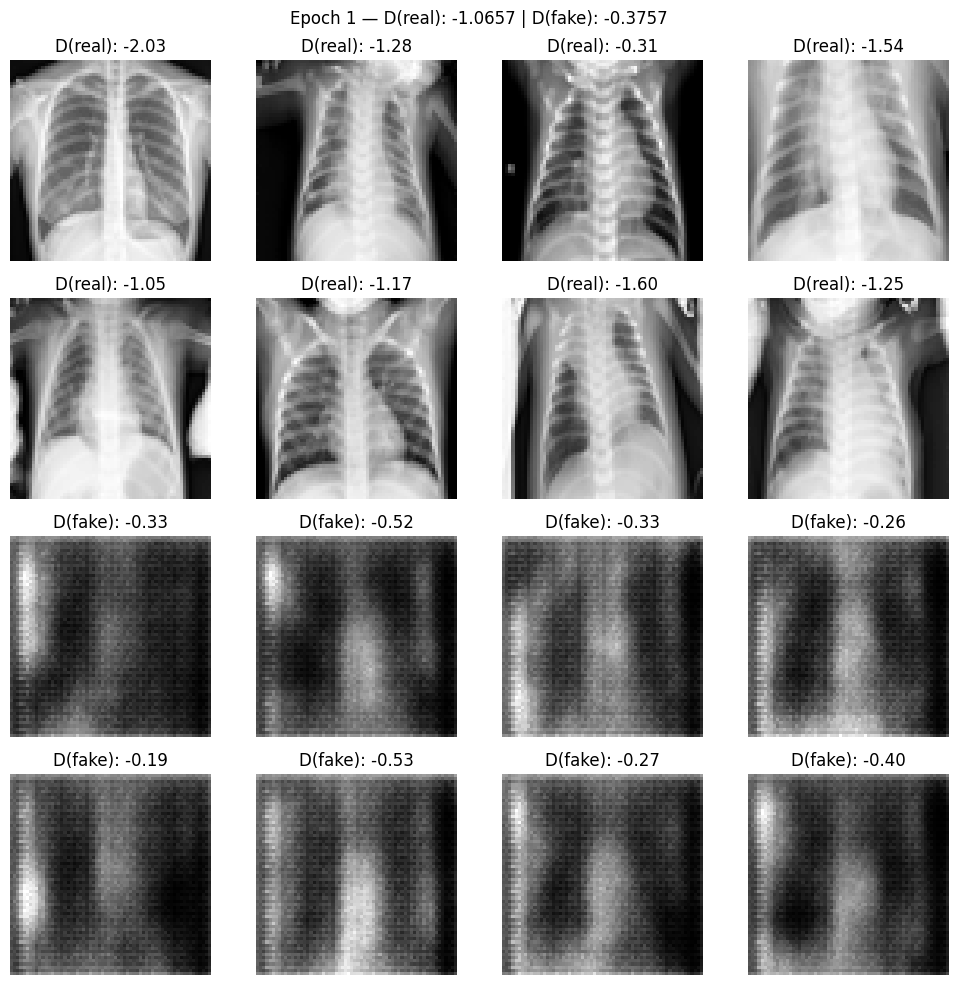

Epoch 2 | Generator loss: 1.1023 | Discriminator loss: 1.0151


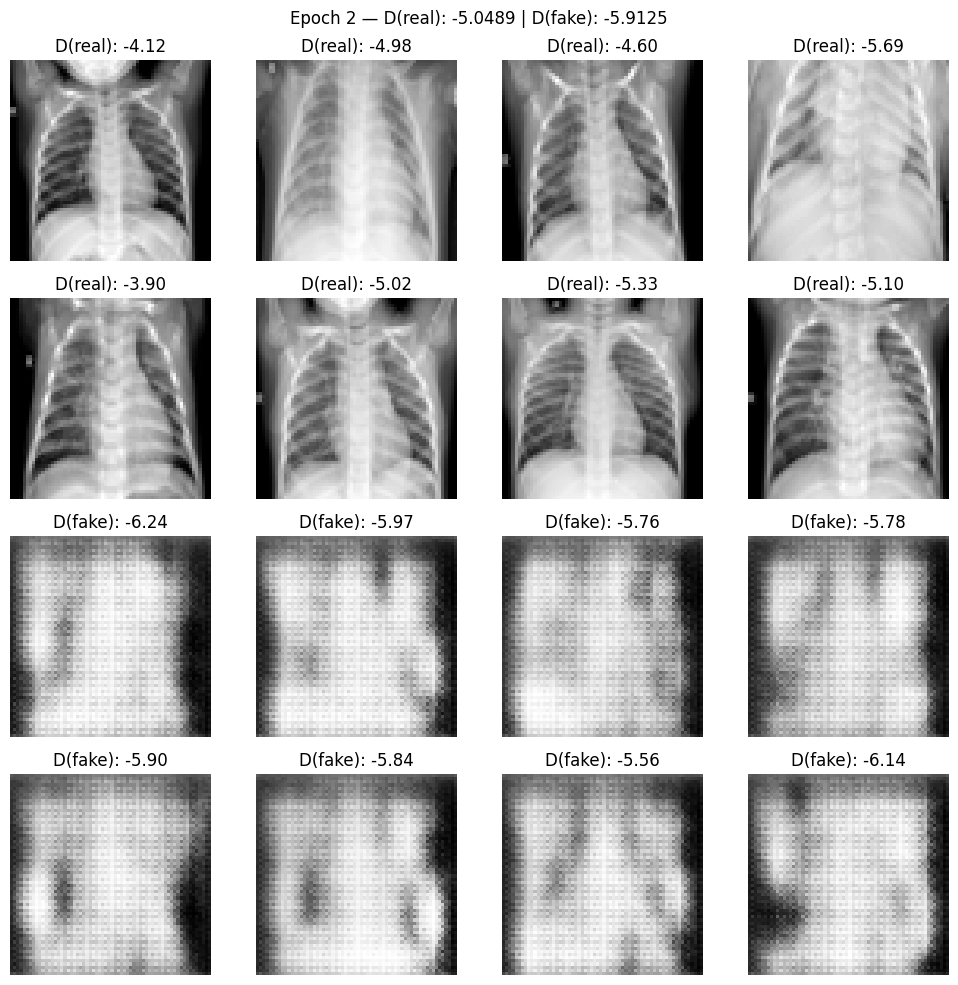

Epoch 3 | Generator loss: 0.9983 | Discriminator loss: 1.1150


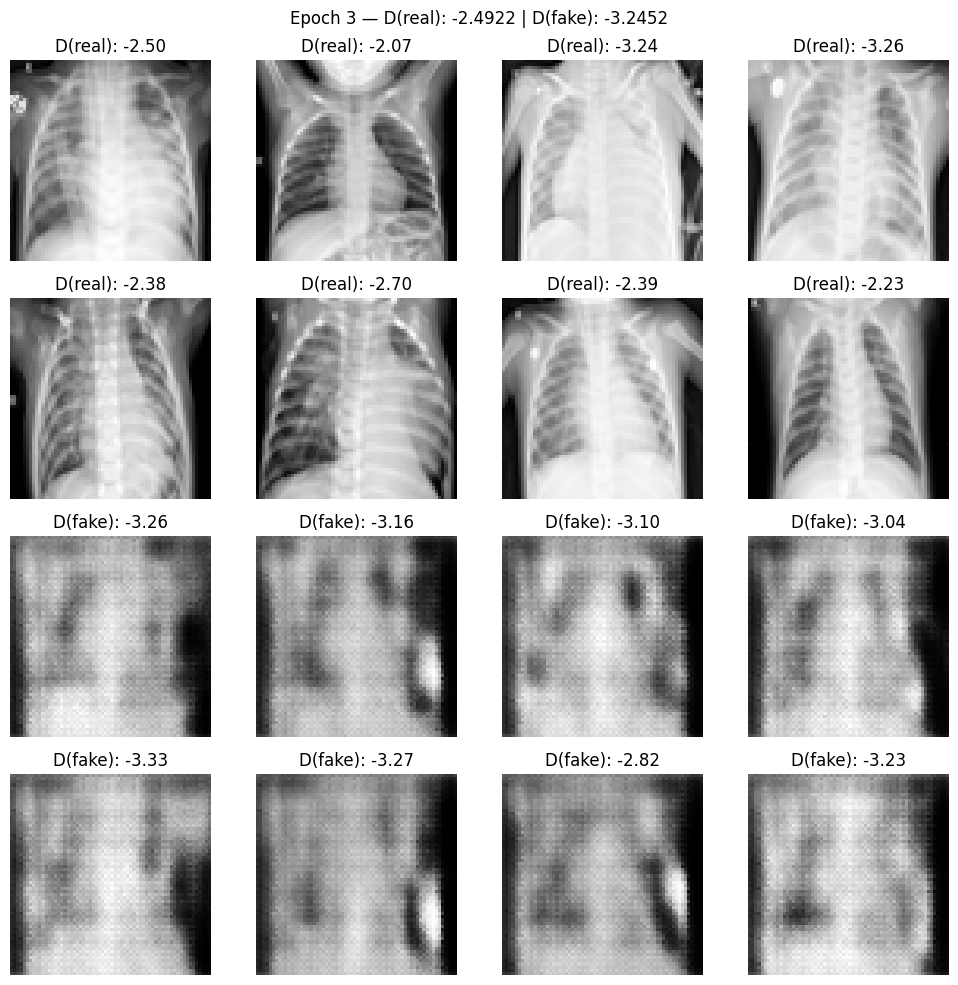

Epoch 4 | Generator loss: 0.8779 | Discriminator loss: 1.2594


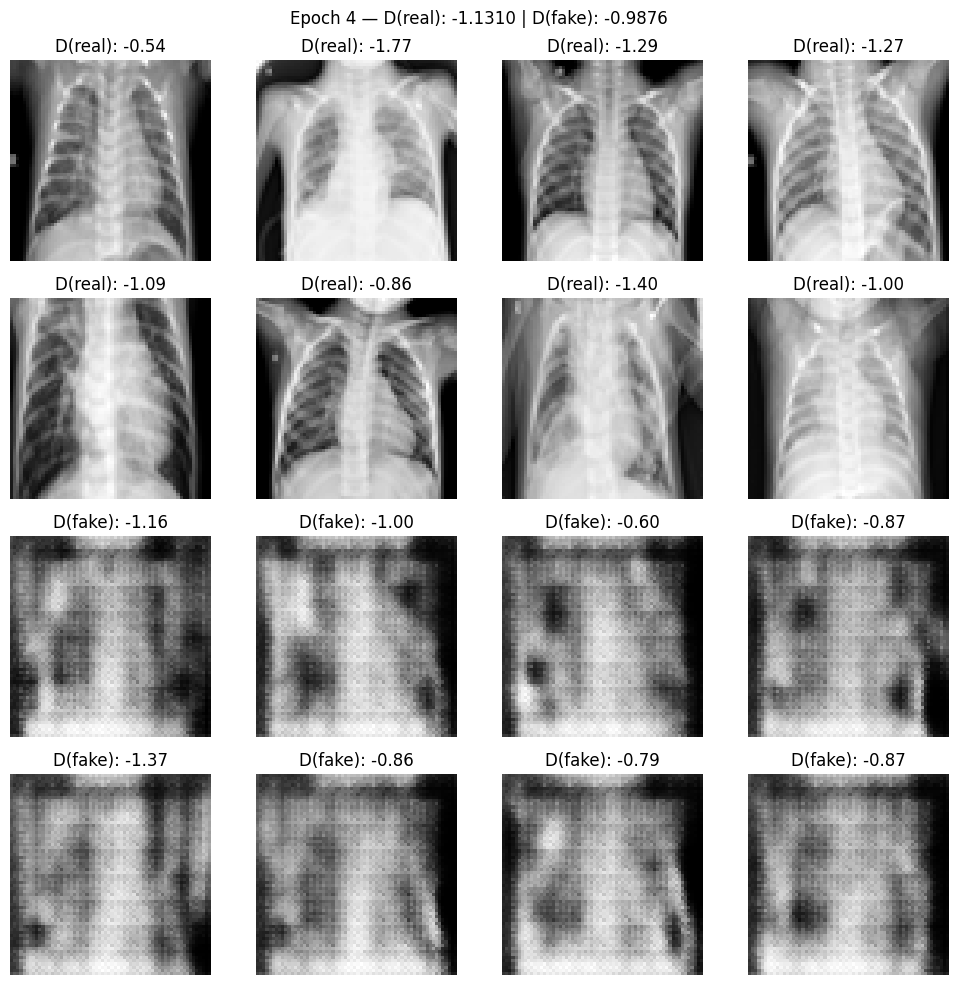

Epoch 5 | Generator loss: 0.7774 | Discriminator loss: 1.3198


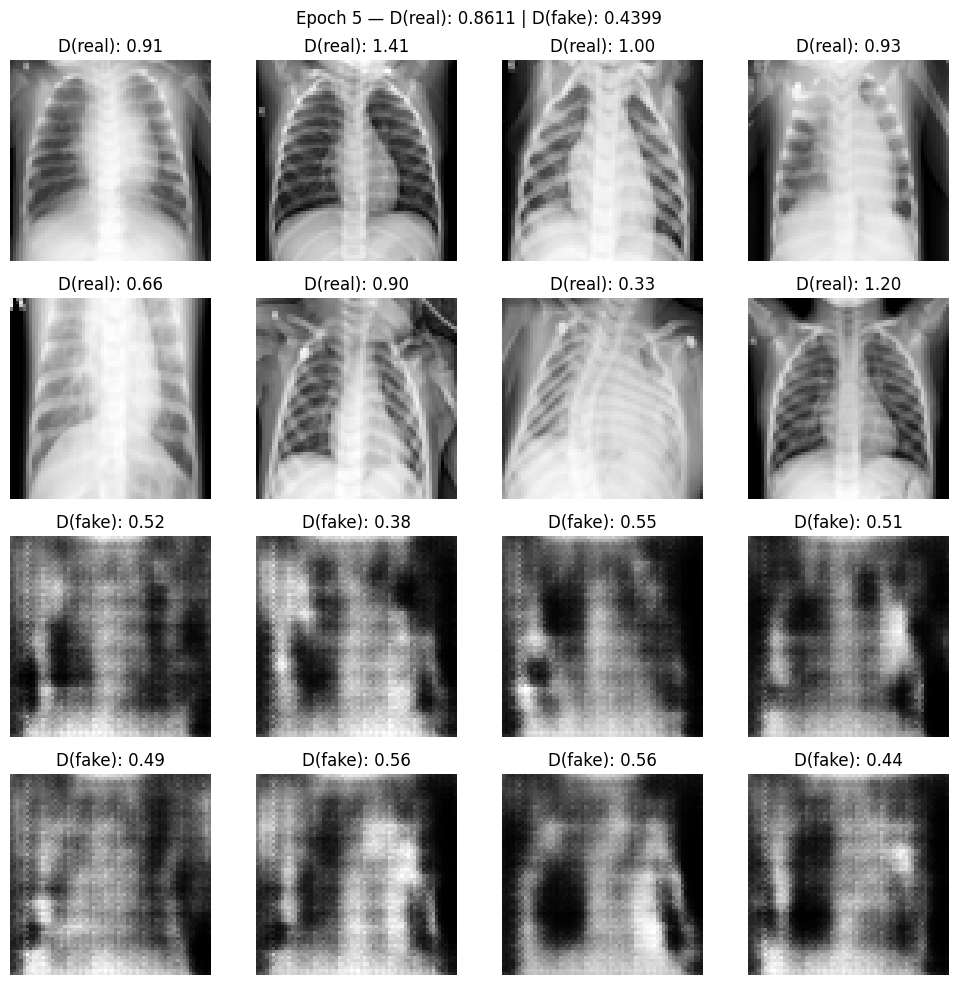

In [ ]:
train(dataset, EPOCHS)